# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 1

> *Modelo de Clasificación para inferir el dígito correspondiente a un clip de audio.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
!pip install pydub

In [2]:
# Data
import os
import pathlib
import numpy as np

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import plotly.graph_objects as go

# ML metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
# from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
# from tensorflow.keras.models import Sequential, load_model, save_model
# from tensorflow.keras.layers import Dense, Input, Dropout

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### GPU

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor

https://www.tensorflow.org/datasets/catalog/spoken_digit

### Descarga

In [3]:
# Cargar el dataset spoken_digit
data, info = tfds.load('spoken_digit', with_info=True, as_supervised=True, split='train')

## Análisis Exploratorio

In [4]:
tfds.as_dataframe(data.take(5), info)

audio  label
0  [0, 0, -256, 0, -256, 0, -256, 0, 0, 0, 0, 0, ...      2
1  [0, 0, 0, 0, -256, 0, -256, 0, -256, 0, -256, ...      1
2  [-10, -6, -25, -20, -17, -24, -26, -30, -30, -...      9
3  [0, 2, -3, -2, -2, -6, -1, -6, -8, -6, -8, -12...      9
4  [-256, 0, -256, 0, 0, -256, -256, 0, -512, 0, ...      7

In [5]:
shuffled_data = data.shuffle(len(data), seed=seed)
sample_data = shuffled_data.take(5)
df_sample = tfds.as_dataframe(sample_data, info)
df_sample

audio  label
0  [-548, -435, 27, -283, 802, -516, -72, 244, 21...      3
1  [-276, -65, -87, -430, -177, -151, 52, 369, -3...      3
2  [6, 9, 3, 2, 10, 7, 8, 6, 32, 31, 47, 43, 31, ...      1
3  [0, -256, -256, -256, -256, -256, 0, -256, -25...      6
4  [0, -10, -27, 29, -21, 9, -3, 15, -28, 29, -9,...      6

In [6]:
label_names = info.features['label'].names
print("Label names:", label_names)

Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
# Obtener la duración de cada clip de audio
def get_audio_duration(audio):
    return tf.shape(audio)[0]

# Obtener las duraciones de todos los clips de audio en el dataset
durations = np.array([get_audio_duration(audio) for audio, _ in data])

# Calcular el número total de clips de audio
num_clips = len(durations)

# Calcular la duración mínima, máxima y promedio de los clips de audio
min_duration = np.min(durations)
max_duration = np.max(durations)
avg_duration = np.mean(durations)

# Imprimir el resumen estadístico
print(f"Número total de clips de audio: {num_clips}")
print(f"Duración mínima de los clips de audio: {min_duration} muestras")
print(f"Duración máxima de los clips de audio: {max_duration} muestras")
print(f"Duración promedio de los clips de audio: {avg_duration} muestras")

Número total de clips de audio: 2500
Duración mínima de los clips de audio: 1148 muestras
Duración máxima de los clips de audio: 18262 muestras
Duración promedio de los clips de audio: 3280.632 muestras


In [36]:
def durations_boxplot(ds, w=10, h=3):
    fig = go.Figure()
    fig.add_trace(go.Box(x=ds, orientation='h', name='Clips de Audio'))
    fig.update_layout(
        title='<b>Duraciones de Clips de Audio</b>',
        title_x=0.5,  # Alinea el título en el centro del gráfic
        xaxis_title='Duración (muestras)',
        template='simple_white',
        height=h*100,
        width=w*100,
        xaxis=dict(
            tickvals=np.arange(0, np.max(ds) + 1000, 1000),
            ticktext=[f'{val//1000}k' for val in np.arange(0, np.max(ds) + 1000, 1000)]
        )
    )
    return fig.show()

In [38]:
durations_boxplot(durations, 10, 3)

In [39]:
def durations_histogram(ds, w=10, h=5):
    # Definir los bins del histograma (de 1000 en 1000 muestras)
    bins = np.arange(0, np.max(ds) + 1000, 1000)

    plt.figure(figsize=(w, h))
    plt.hist(ds, bins=bins, edgecolor='lightblue')
    plt.xticks(np.arange(0, np.max(ds) + 1000, 1000), [f'{val//1000}k' for val in np.arange(0, np.max(ds) + 1000, 1000)])
    plt.title('Histograma de Duraciones de Clips de Audio')
    plt.xlabel('Duración (muestras)')
    plt.ylabel('Cantidad de Clips')
    return plt.show()

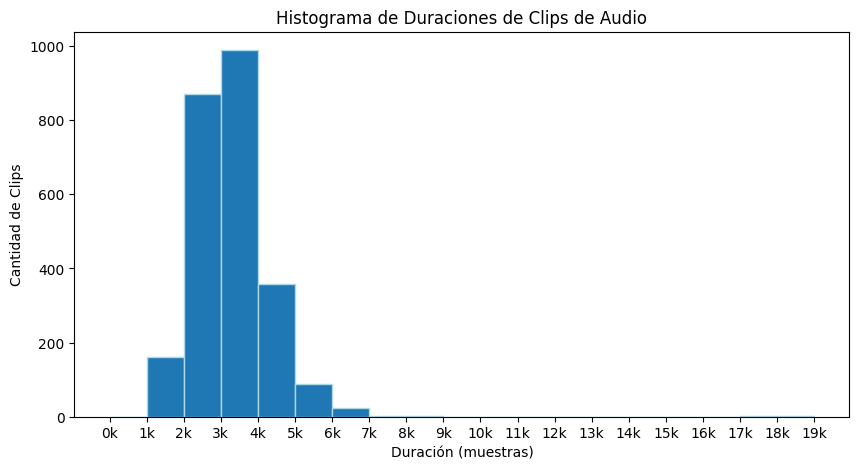

In [44]:
durations_histogram(durations, 10, 5)

## Conjuntos de Train y Val

In [86]:
# Contar el número de elementos en el dataset
data_size = len(data)

# Determinar el tamaño del conjunto de validación
val_size = int(data_size * 0.2)

# Shuffle el dataset antes de dividir
shuffled_data = data.shuffle(data_size, seed=seed)

# Crear datasets de entrenamiento y validación
train_ds = shuffled_data.skip(val_size)
val_ds = shuffled_data.take(val_size)

In [87]:
len(train_ds), len(val_ds)

(2000, 500)

In [88]:
# Batch y preparar el dataset
# train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [89]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


## Procesamiento

### Normalizar las muestras

In [90]:
m_muestras = 5000  # Equivale a 1 segundo de archivo wav a 8 kHz

In [91]:
def preprocess(audio, label):
    # Normalizar y convertir a float32
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Asegurarse de que todos los audios tengan exactamente las muestras deseadas
    # Recortar si el audio es más largo; rellenar con ceros si es más corto
    audio = audio[:m_muestras]  # Recorta si es más largo que las muestras deseadas
    padding = tf.maximum(0, m_muestras - tf.shape(audio)[0])  # Cantidad de padding necesaria
    audio = tf.pad(audio, [[0, padding]], "CONSTANT")  # Aplicar padding

    return audio, label

In [92]:
# Aplicar el preprocesamiento al dataset
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [93]:
train_durations = np.array([get_audio_duration(audio) for audio, _ in train_ds])

In [94]:
durations_boxplot(train_durations, 8, 3)

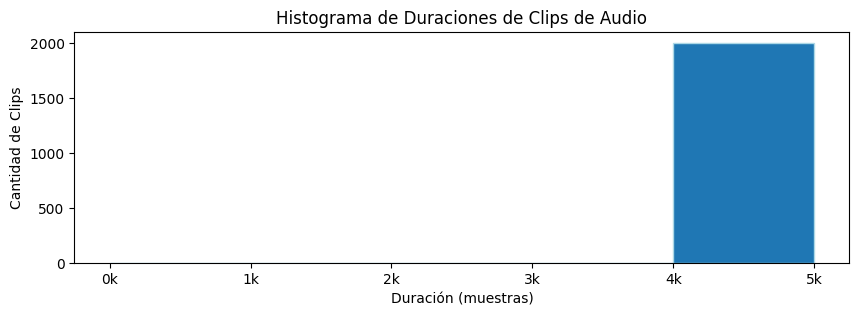

In [95]:
durations_histogram(train_durations, 10, 3)

In [96]:
# Batch y prefetch en los datasets
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Batch y prefetch
train_ds = train_ds.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [97]:
# Iterar sobre un lote de datos en train_data
for audio, label in train_ds.take(1):
    print("Forma del audio en un lote:", audio.shape)  # Esto mostrará la forma del tensor de audio
    print("Forma de las etiquetas en un lote:", label.shape)  # Esto mostrará la forma del tensor de etiquetas

Forma del audio en un lote: (64, 5000)
Forma de las etiquetas en un lote: (64,)


In [98]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Label: 2
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)
Audio playback


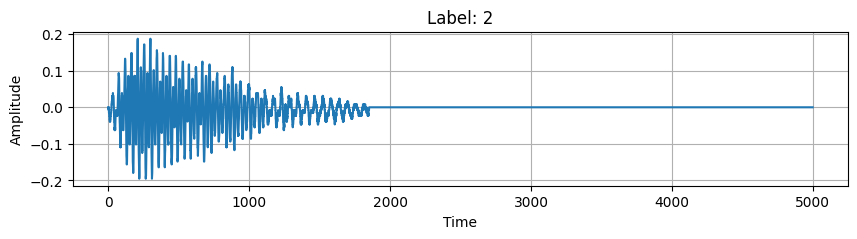

------------------------
Label: 0
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)
Audio playback


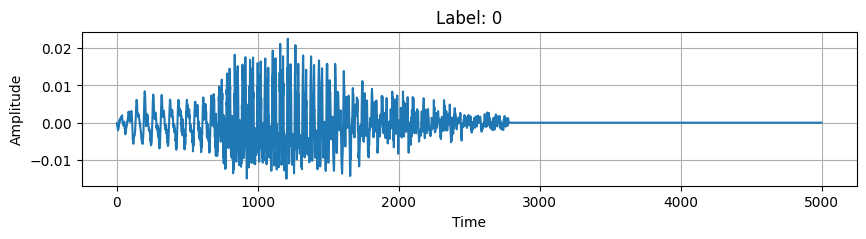

------------------------
Label: 5
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)
Audio playback


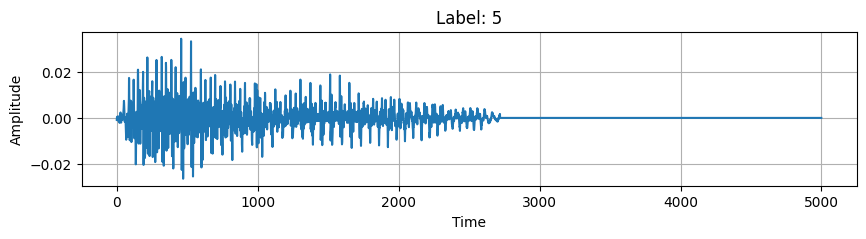

------------------------
Label: 2
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)
Audio playback


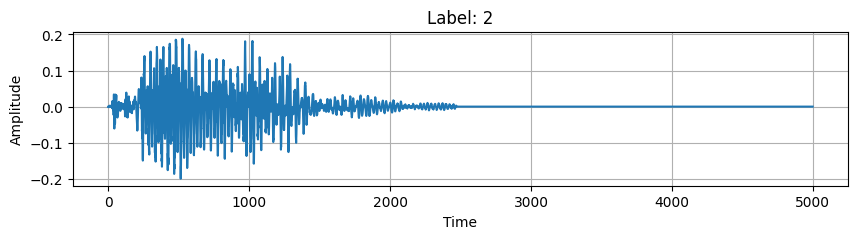

------------------------
Label: 6
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)
Audio playback


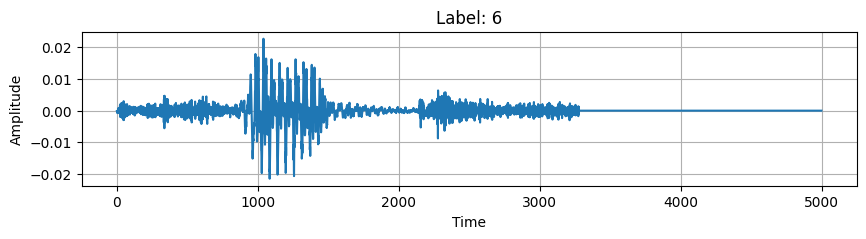

------------------------


In [100]:
# Procesando el lote de datos
for audio, label in train_ds.take(1):  # toma un lote del dataset
    for i in range(min(5, audio.shape[0])):  # Procesa solo los primeros ejemplos del lote
        waveform = audio[i].numpy()  # Extrae el audio y conviértelo a numpy
        label_index = label[i].numpy()  # Extrae el índice de la etiqueta y conviértelo a numpy
        label_name = label_names[label_index]  # Usa el índice para obtener el nombre de la etiqueta

        print('Label:', label_name)
        print('Waveform shape:', waveform.shape)
        spectrogram = get_spectrogram(waveform)
        print('Spectrogram shape:', spectrogram.shape if spectrogram is not None else "Spectrogram not generated")
        print('Audio playback')
        display.display(display.Audio(waveform, rate=8000))

        # Opcional: Visualizar la forma de onda
        plt.figure(figsize=(10, 2))
        plt.plot(waveform)
        plt.title(f'Label: {label_name}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
        print('------------------------')

In [101]:
def plot_spectrogram(spectrogram, ax):
    # Eliminar la dimensión extra innecesaria
    spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convertir las frecuencias a escala logarítmica y transponer para que el tiempo esté representado en el eje x (columnas).
    log_spec = np.log(spectrogram + np.finfo(float).eps)
    ax.imshow(log_spec.T, aspect='auto', origin='lower')
    ax.set_ylabel('Frequency bins')
    ax.set_xlabel('Time [sec]')

In [102]:
# Definición de get_spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

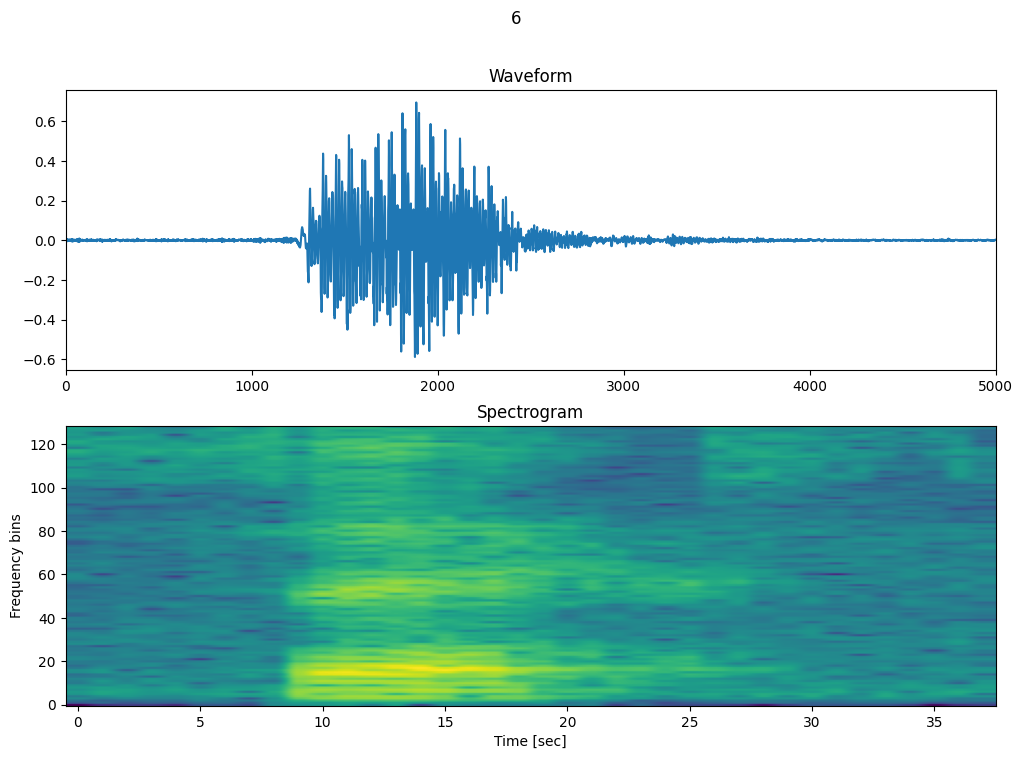

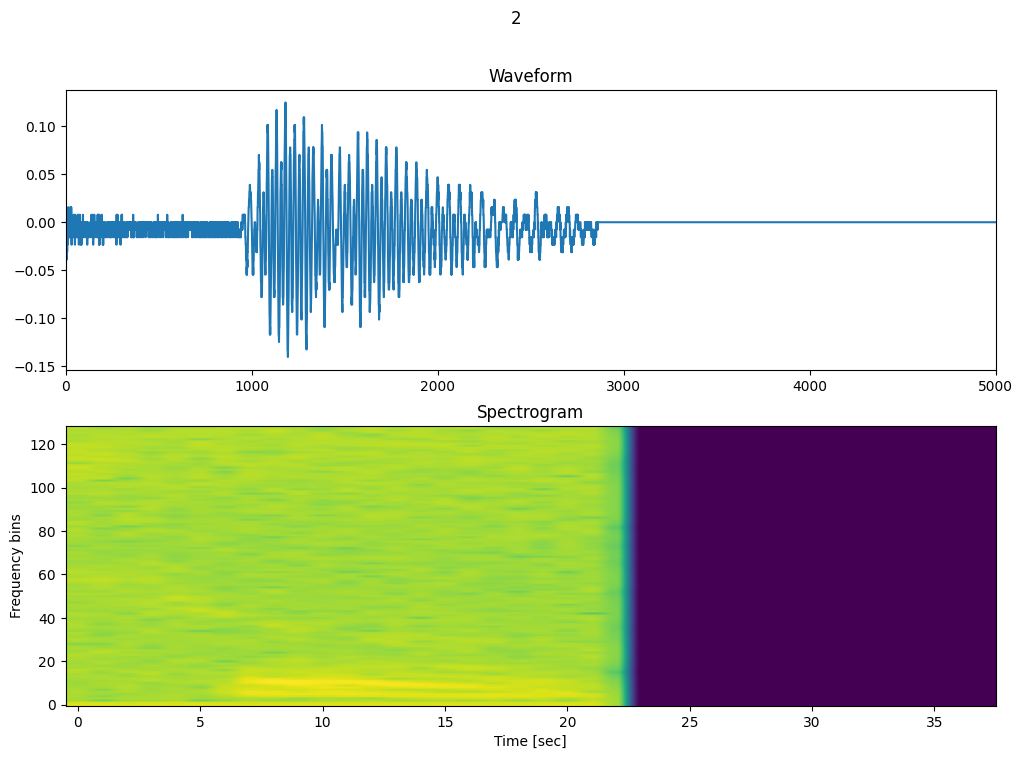

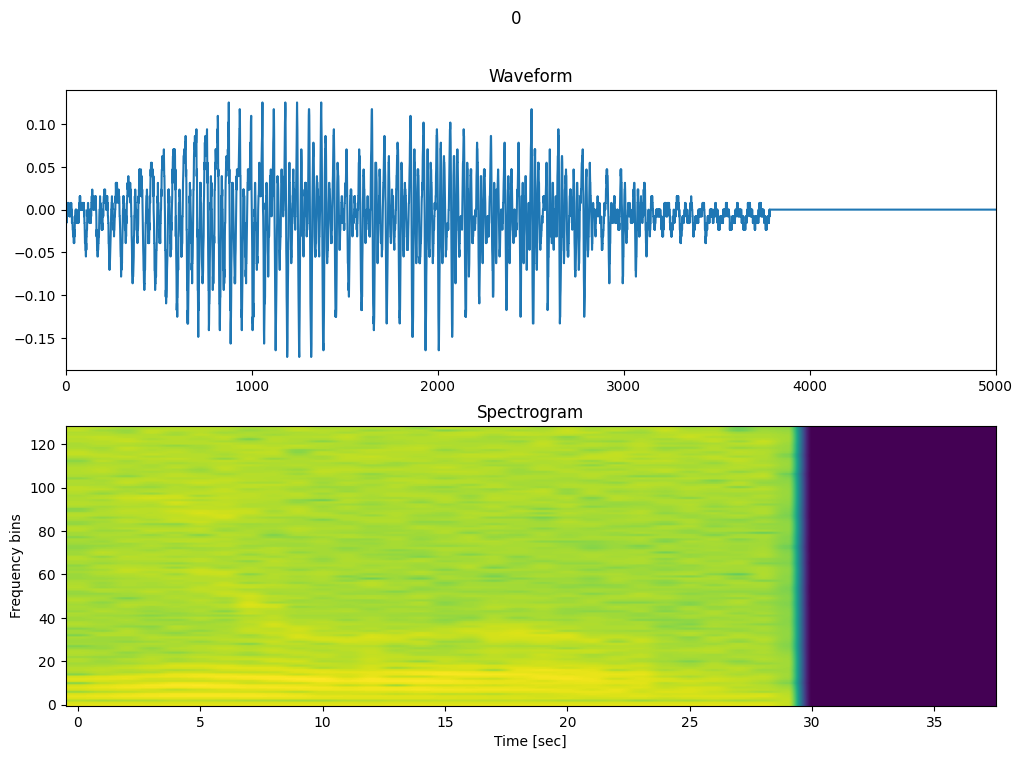

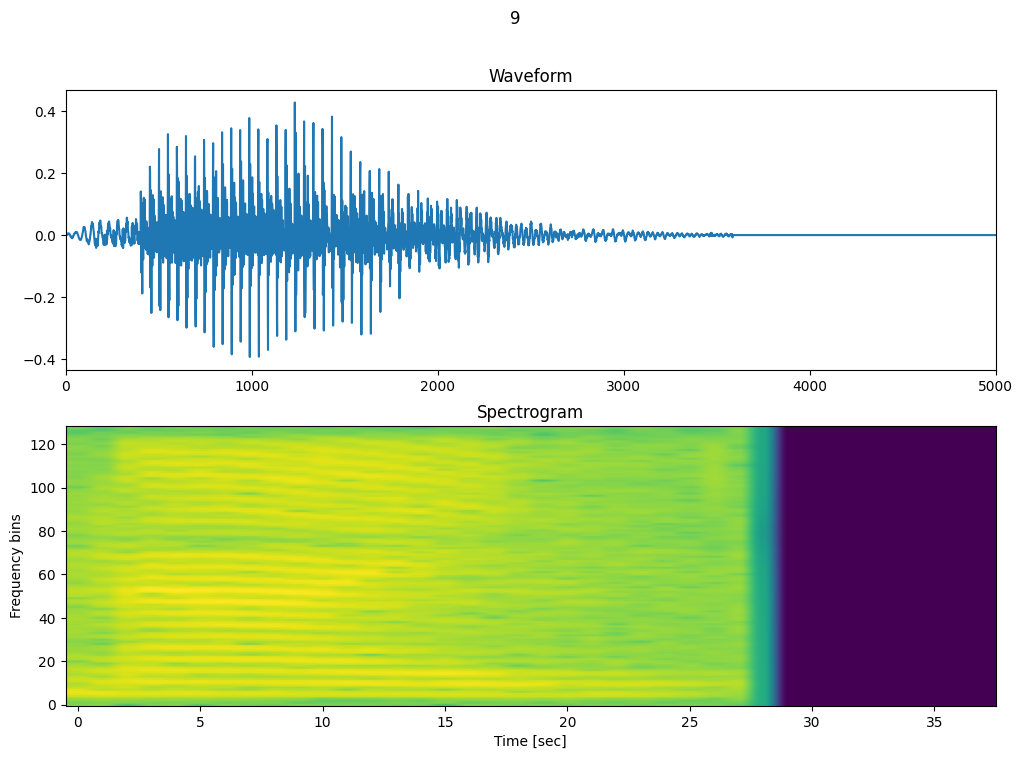

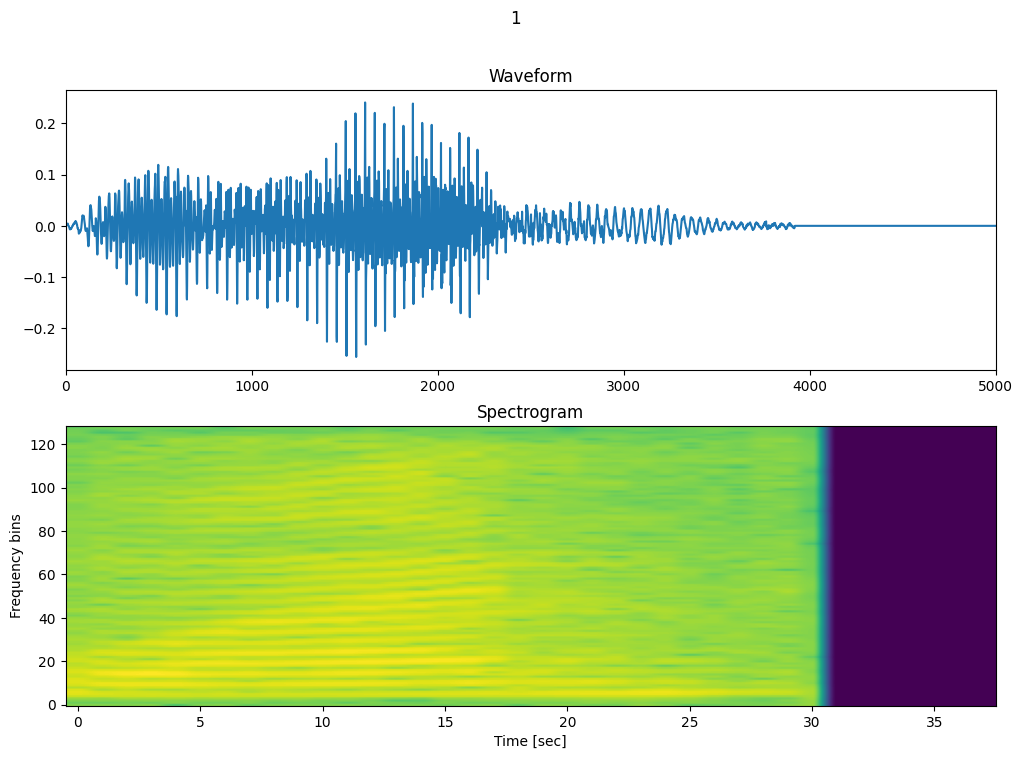

In [103]:
# Procesando el lote de datos
for audio, label in train_ds.take(1):  # toma un lote del dataset
    for i in range(min(5, audio.shape[0])):  # Procesa solo los primeros ejemplos del lote
        waveform = audio[i].numpy()  # Extrae el audio y conviértelo a numpy
        label_index = label[i].numpy()  # Extrae el índice de la etiqueta y conviértelo a numpy
        label_name = label_names[label_index]  # Usa el índice para obtener el nombre de la etiqueta

        spectrogram = get_spectrogram(waveform)

        # Crear figuras para visualizar la forma de onda y el espectrograma
        fig, axes = plt.subplots(2, figsize=(12, 8))
        timescale = np.arange(waveform.shape[0])
        axes[0].plot(timescale, waveform)
        axes[0].set_title('Waveform')
        axes[0].set_xlim([0, waveform.shape[0]])

        plot_spectrogram(spectrogram.numpy(), axes[1])  # Asegúrate de que el espectrograma sea numpy y ajustado
        axes[1].set_title('Spectrogram')
        plt.suptitle(label_name.title())
        plt.show()

# CNN / Clasificación

## Modelo

### Definición y entrenamiento

In [ ]:
# Definición del Modelo
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
print("-------------------------\nFin del Entrenamiento")

### Visualización de Métricas

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Predicciones

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferencia

Inferimos sobre un archivo de audio (en este caso tomamos un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Observaciones finales

Puede concluirse que para la resolución de este problema, el dataset provisto entrega unos datos muy generosos, tanto en el comportamiento de las variables como en la distribución de las mismas.

El modelo de red neuronal densa para este problema de regresión logra unos resultados excelentes sin demasiado esfuerzo ni complejidad en la arquitectura.